In [39]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.max_rows = 99999

import warnings
warnings.filterwarnings("ignore")

def allsymbols(path):
    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    allsymbol=[]
    symbols=mt5.symbols_get()
    count=0
    for s in symbols:
        count+=1
        allsymbol.append(s.name)
    return allsymbol

def readdata(market,tf,barre,path):
    from datetime import datetime
    import MetaTrader5 as mt5
    import pandas as pd

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    
    mk=str(market)
    TF="mt5.TIMEFRAME_"+str(tf)
    bar=barre
    
    cnt=0
    salta=0
    while True:
        cnt=cnt+1
        try:
            rates = mt5.copy_rates_from_pos(mk, eval(TF), 0, bar) #1700
            if len(rates)>0:
                break
        except:
            if cnt<2:
                continue
            else:
                salta=1
                break
    if salta == 0:
        rates_frame = pd.DataFrame(rates)
        rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
        rates_frame=rates_frame[["time","open","high","low","close","tick_volume"]]
        rates_frame.columns=(["time","open","high","low","close","volume"])
        rates_frame=rates_frame.set_index(["time"])
        rates_frame=rates_frame[(rates_frame.T != 0).any()]
        return rates_frame
    else:
        return pd.DataFrame()
    
def get_poin_values(path,simb):

    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    tmp=symbol_info_dict['trade_tick_value']/symbol_info_dict['point']
    return tmp

def ordine_market(mercato,quantita,deviazione,path,direzione,commento):
    import time
    import pymt5adapter as mta
    from pymt5adapter.order import  Order
    
    mta.initialize(path)
    status=0
    if direzione == "long":
    
        order = Order.as_buy(symbol=mercato , 
                              volume=float(quantita),
                              #magic=int(magic),
                              type_filling=1,
                              #tp=float(target),
                              #sl=float(stop),
                              deviation=deviazione,
                              comment=commento)
    
    if direzione == "short":
    
        order = Order.as_sell(symbol=mercato , 
                              volume=float(quantita),
                              #magic=int(magic),
                              type_filling=1,
                              #tp=float(target),
                              #sl=float(stop),
                              deviation=deviazione,
                              comment=commento)
    while True: 
        r = order.send()
        time.sleep(1)
        if r[7]=='Request executed':
            print(r,'Request executed')
            status=1
            break
        if r[7]=="Market closed":
            print(r[7],"Market closed")
            status=0
            break
    return status

def check_start_sessiona(path,simbolo):
    x=readdata(simbolo,"M1",3000,path)
    y=list(set(x.index.hour))
    y.sort()
    z=x.index.minute[x.index.hour==y[0]]
    z=list(set(z))
    z.sort()
    return y[0],z[0]

def check_end_sessiona(path,simbolo):
    x=readdata(simbolo,"M1",3000,path)
    y=list(set(x.index.hour))
    y.sort()
    z=x.index.minute[x.index.hour==y[-1]]
    z=list(set(z))
    z.sort()
    return y[-1],z[-1]

def get_spread(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    try:
        if len(symbol_info)>0:
            return symbol_info.spread
    except:
        return None
    
def get_category(path,simb):
    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    return symbol_info_dict['path']

def get_ETF(path,simb):
    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    return symbol_info_dict['description']
    
    
def get_min_contract(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    return symbol_info.volume_min

def get_max_contract(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    return symbol_info.volume_max

def remove_outlier(y):
    Q1 = np.percentile(y, 20, #25
                       interpolation = 'midpoint')
    Q3 = np.percentile(y, 80, #75
                       interpolation = 'midpoint')
    IQR = Q3 - Q1
    y[y>=Q3+1.5*IQR]=0
    y[y<=Q1-1.5*IQR]=0
    return y

In [2]:
mt5_simboli=["AUDCAD","AUDCHF","AUDJPY","AUDNZD","AUDUSD","CADCHF","CADJPY","CHFJPY","EURAUD","EURCAD","EURCHF","EURGBP","EURJPY",\
            "EURNZD","EURUSD","GBPAUD","GBPCAD","GBPCHF","GBPJPY","GBPNZD","GBPUSD","NZDCAD","NZDCHF","NZDJPY","NZDUSD","USDCAD",\
            "USDCHF","USDJPY"]

In [111]:
path=(r"C:\Program Files\ICMarkets - MetaTrader 5 1\terminal64.exe")

import pandas as pd
from tqdm.notebook import tqdm

data=pd.DataFrame()
targets=pd.DataFrame()
for e in tqdm(mt5_simboli): 
    x=readdata(e,"D1",2000,path)
    x=x.loc["2016-01-01":]
    if (len(x.dropna())>80):
        if(x.open.iloc[-1]!=np.nan):
            tg=x.close-x.open
            tg=tg*get_poin_values(path,e)
            tg=tg.to_frame()
            tg = remove_outlier(tg.dropna())
            x=x.open.to_frame()
            x.columns=([e]) 
            tg.columns=([e]) 
            data=pd.concat([data,x],axis=1)
            targets=pd.concat([targets,tg],axis=1)
data=data[(data.index.dayofweek != 5)&(data.index.dayofweek != 6)]
targets=targets[(targets.index.dayofweek != 5)&(targets.index.dayofweek != 6)]
display(data.tail())
display(targets.tail())
data_etf = targets.iloc[:].copy()
data_etf=data_etf.fillna(0)

  0%|          | 0/28 [00:00<?, ?it/s]

,AUDCAD,AUDCHF,AUDJPY,AUDNZD,AUDUSD,CADCHF,CADJPY,CHFJPY,EURAUD,EURCAD,...,GBPJPY,GBPNZD,GBPUSD,NZDCAD,NZDCHF,NZDJPY,NZDUSD,USDCAD,USDCHF,USDJPY
time,,,,,,,,,,,,,,,,,,,,,
2023-07-04,0.88313,0.59799,96.507,1.08416,0.66722,0.67578,109.136,161.343,1.63487,1.44528,...,183.597,2.06216,1.26922,0.81488,0.55112,88.958,0.61504,1.32467,0.89625,144.643
2023-07-05,0.88423,0.60012,96.546,1.08064,0.66840,0.67823,109.214,160.982,1.62544,1.43851,...,183.608,2.05243,1.27105,0.81853,0.55513,89.310,0.61903,1.32228,0.89570,144.448
2023-07-06,0.88358,0.59739,96.133,1.07620,0.66519,0.67636,108.910,160.778,1.63089,1.44135,...,183.746,2.05596,1.27032,0.82017,0.55493,89.323,0.61778,1.32801,0.89847,144.638
2023-07-07,0.88500,0.59157,95.287,1.07570,0.66153,0.66944,107.731,160.882,1.64316,1.45502,...,183.515,2.06868,1.27395,0.82223,0.55097,88.642,0.61550,1.33667,0.89512,144.044
2023-07-10,0.88607,0.59345,94.918,1.07486,0.66837,0.66888,106.959,159.846,1.63799,1.45394,...,182.390,2.06450,1.28315,0.82292,0.55086,88.176,0.62026,1.32708,0.88886,142.114


,AUDCAD,AUDCHF,AUDJPY,AUDNZD,AUDUSD,CADCHF,CADJPY,CHFJPY,EURAUD,EURCAD,...,GBPJPY,GBPNZD,GBPUSD,NZDCAD,NZDCHF,NZDJPY,NZDUSD,USDCAD,USDCHF,USDJPY
time,,,,,,,,,,,,,,,,,,,,,
2023-07-04,116.005299,242.969767,110.931569,-180.293217,180.508706,274.750623,77.587976,-212.244793,-562.078289,-465.394040,...,43.603160,-499.056145,189.625308,255.348943,428.528956,300.092336,369.222354,-164.054831,88.166245,-110.290346
2023-07-05,-22.651922,-207.088156,-182.748538,-205.726429,-268.939739,-167.105789,-206.473787,-41.038268,337.977736,217.595739,...,98.107110,189.336137,-59.257909,145.521440,2.050378,16.671796,-108.487556,411.166711,319.858934,129.527034
2023-07-06,142.089331,-431.604523,-439.237714,-3.956277,-237.943295,-682.775801,-734.200267,77.587976,786.178842,1002.862379,...,-147.481276,724.563962,328.197648,190.825285,-387.521401,-414.230019,-192.360288,602.678418,-330.110823,-369.985637
2023-07-07,232.010598,347.539034,-129.527034,96.081025,698.331662,26.654911,-447.573612,-700.215451,-262.465593,71.387876,...,-680.337540,-87.603287,914.395114,143.462175,117.896722,-264.183851,496.854773,-626.016762,-611.012579,0.000000
2023-07-10,-2.059266,-89.191434,-12.183236,122.079419,-51.964628,-71.763222,31.419924,-10.259567,68.813485,68.642189,...,1.923669,120.949054,30.996445,-97.471908,-154.803523,-85.282651,-102.105935,-0.686422,-148.652389,-3.206115


In [112]:
etf_return=pd.DataFrame()
for e in range(len(data_etf.columns)):
    x=data_etf.iloc[:,e].copy() 
    x=x.to_frame()
    #x.columns=([data_etf.iloc[:,e].name+"_long"])
    #y=x.copy()*(-1)
    #y.columns=([data_etf.iloc[:,e].name+"_short"])
    etf_return = pd.concat([etf_return,x],axis=1).fillna(0)
    
#etf_return = etf_return-10 ##### commissioni    

In [113]:
etf_return.head()

,AUDCAD,AUDCHF,AUDJPY,AUDNZD,AUDUSD,CADCHF,CADJPY,CHFJPY,EURAUD,EURCAD,...,GBPJPY,GBPNZD,GBPUSD,NZDCAD,NZDCHF,NZDJPY,NZDUSD,USDCAD,USDCHF,USDJPY
time,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-192.884551,-870.385369,0.000000,-70.647812,-834.169022,-622.289657,-886.170104,-705.345234,903.709839,653.473638,...,-822.689033,1327.613686,-126.720759,-79.624939,-684.826179,-922.719811,-717.476525,941.770831,139.425689,-480.275982
2016-01-05,-58.345861,173.256923,-380.245204,212.508619,-278.056341,292.178834,-355.878732,-738.047604,-325.189389,-433.132212,...,-651.482507,501.882058,-363.752393,-201.121613,4.100756,-501.436339,-407.512079,315.754069,674.574290,-247.512055
2016-01-06,-446.860649,-1009.811058,-939.391608,-172.380662,-802.260917,-513.619634,-588.001436,-260.977737,0.000000,945.202941,...,-866.933415,922.377836,-381.073936,-266.331693,-768.891668,-737.406381,-592.579087,570.416589,-135.324934,-373.191751
2016-01-07,-392.633320,0.000000,-826.536370,-412.583223,-546.996080,0.000000,-516.825690,576.459423,0.000000,0.000000,...,-845.773058,53.127155,-103.017595,9.609906,0.000000,-461.680517,-133.102379,266.331693,0.000000,-512.978352
2016-01-08,-304.084897,-485.939534,-636.093157,269.592051,-536.056158,-191.710323,-414.230019,-471.940084,713.711544,433.132212,...,-1131.117267,714.955859,-892.515270,-525.799167,-695.078068,-757.284293,-732.974747,432.445790,150.702767,-266.748743


<Axes: xlabel='time'>

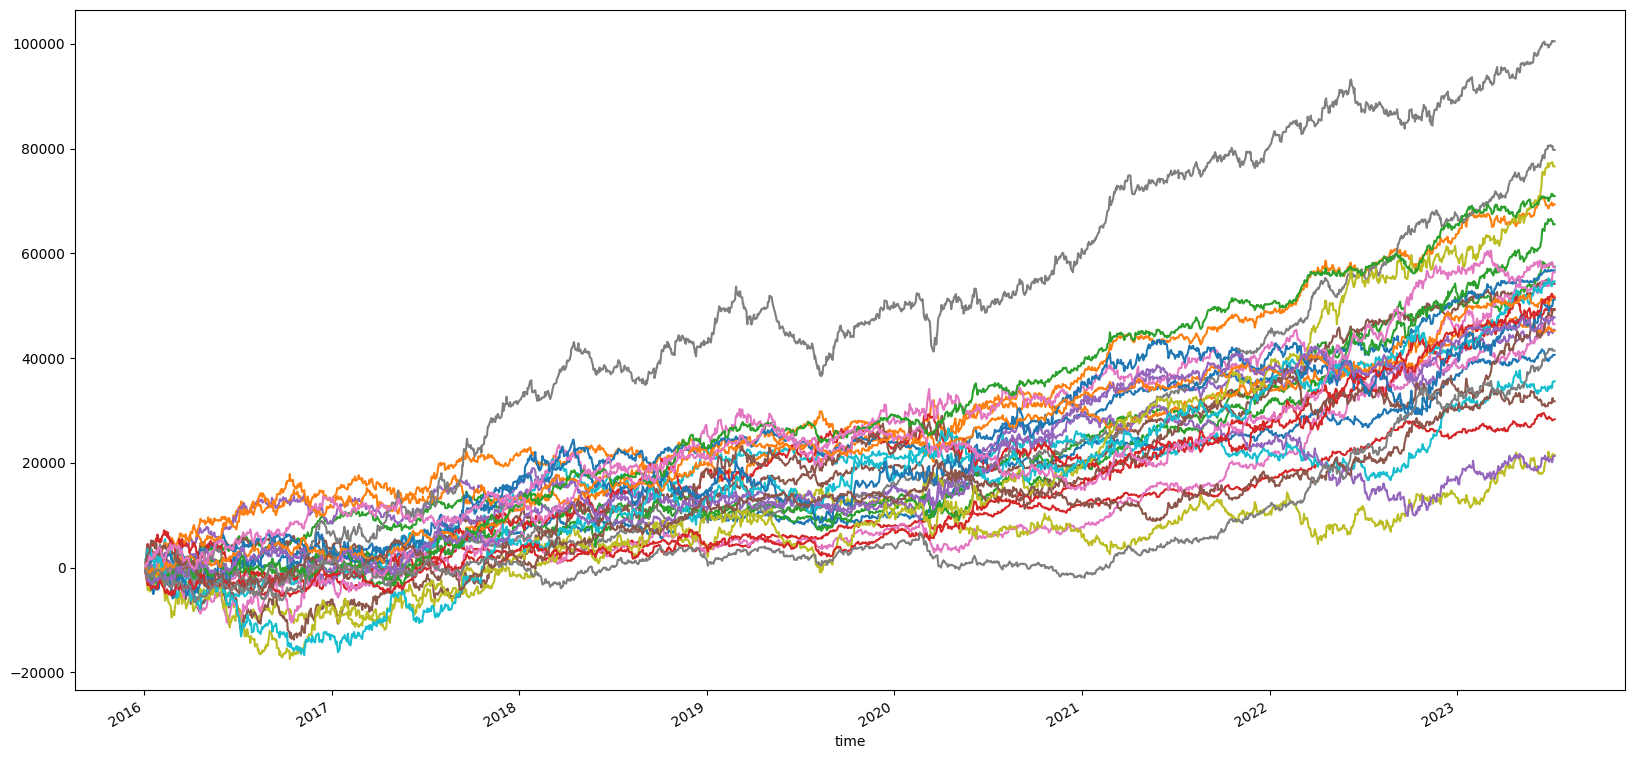

In [114]:
etf_return.cumsum().plot(legend=None,figsize=(20,10))

In [115]:
w=etf_return.cumsum().std().to_frame()
w.columns=(["STD"])
w["MAX"] = w.STD.max()
w["W"] = w.MAX/w.STD

newdf=etf_return.copy()
for e in newdf.columns:
    S = w.W[w.index==e]
    newdf[e] = newdf[e] * float(S)

In [116]:
newdf.tail()

,AUDCAD,AUDCHF,AUDJPY,AUDNZD,AUDUSD,CADCHF,CADJPY,CHFJPY,EURAUD,EURCAD,...,GBPJPY,GBPNZD,GBPUSD,NZDCAD,NZDCHF,NZDJPY,NZDUSD,USDCAD,USDCHF,USDJPY
time,,,,,,,,,,,,,,,,,,,,,
2023-07-04,297.596803,411.965141,217.277977,-605.179430,450.653686,528.383377,176.450775,-278.193024,-2142.846669,-1364.321676,...,55.937972,-837.626489,384.183517,520.754014,587.612874,571.724014,716.472321,-524.254350,180.310703,-291.222200
2023-07-05,-58.110618,-351.126407,-357.943488,-690.549569,-671.428472,-321.367502,-469.563219,-53.789588,1288.493934,637.890813,...,125.860438,317.785814,-120.057349,296.773793,2.811545,31.762445,-210.519028,1313.926174,654.150457,342.016770
2023-07-06,364.512061,-731.803056,-860.320314,-13.279799,-594.043496,-1313.072123,-1669.720144,101.695939,2997.199404,2939.932108,...,-189.201966,1216.123623,664.933011,389.165634,-531.381977,-789.174600,-373.273234,1925.921837,-675.116818,-976.948892
2023-07-07,595.193607,589.266594,-253.700297,322.509414,1743.437999,51.261074,-1017.873066,-917.784840,-1000.614209,209.276481,...,-872.796894,-147.035227,1852.577249,292.574164,161.663829,-503.312593,964.141765,-2000.501954,-1249.595104,0.000000
2023-07-10,-5.282783,-151.227710,-23.862899,409.776668,-129.733637,-138.010583,71.455273,-13.447397,262.342008,201.227386,...,2.467852,203.003475,62.799229,-198.782446,-212.271636,-162.477123,-198.135555,-2.193533,-304.012232,-8.465762


<Axes: xlabel='time'>

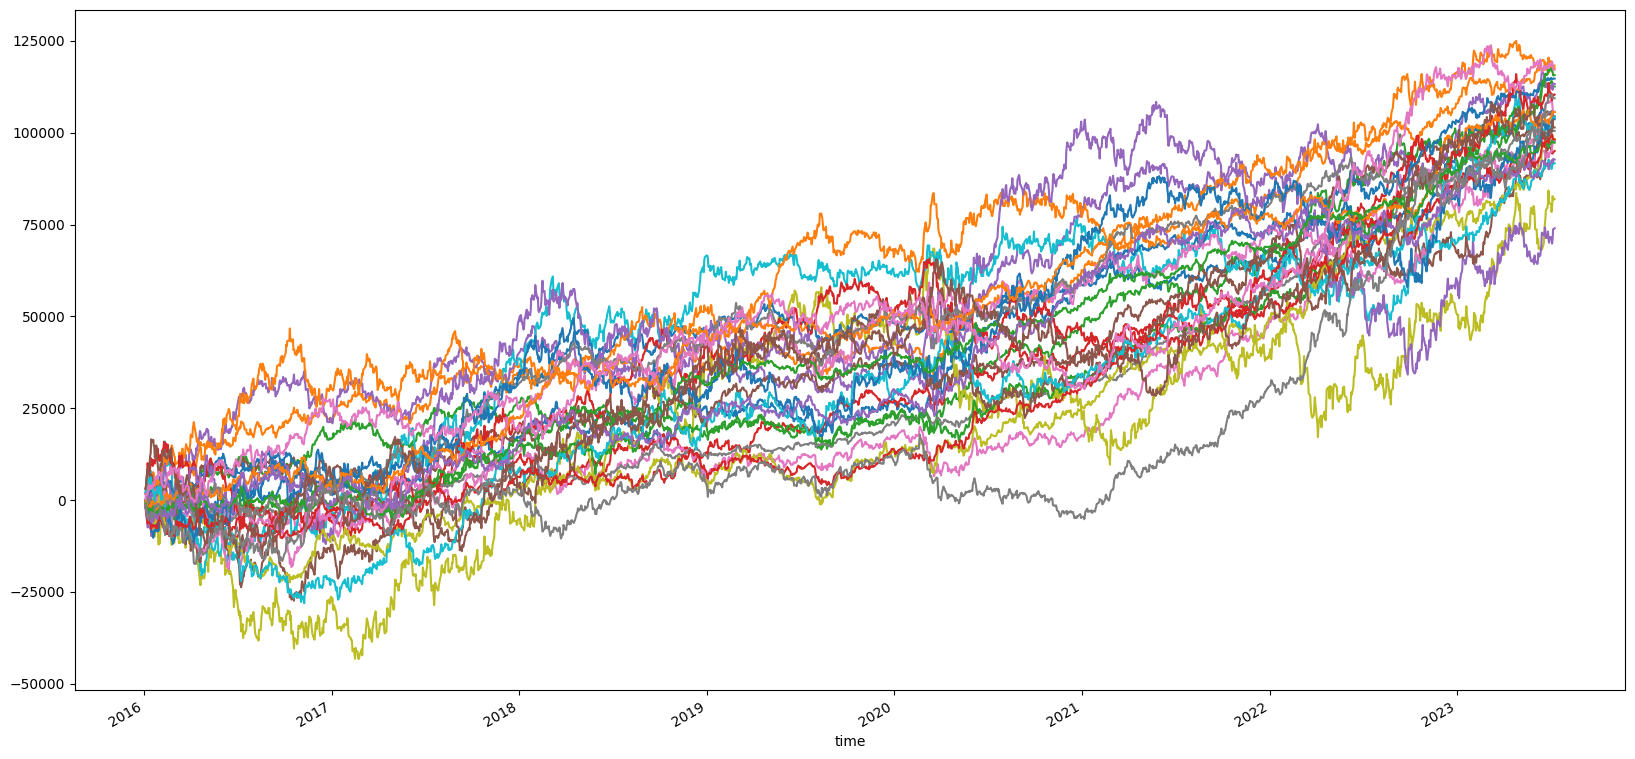

In [117]:
newdf.cumsum().plot(legend=None,figsize=(20,10))

In [118]:
np_arr = newdf.values.T
np_arr_name = newdf.columns.to_list()

In [119]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def kestner_ratio_np(operations):
   
    monthly_equity = np.cumsum(operations)
    index = np.array(np.arange(1,len(operations) + 1))
    
    x = index
    y = monthly_equity
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    if std_err != 0 and len(index) > 0:
        return round(gradient / (std_err * len(index)),5)
    else:
        return np.inf
    
res=[]
results=pd.DataFrame()
for e in tqdm(range(len(np_arr))):
    for i in range(len(np_arr)):
        if np_arr_name[e].split("_")[0]!=np_arr_name[i].split("_")[0]:
            if np.corrcoef(np_arr[e], np_arr[i])[1][0] <= -0.3:
                x=np_arr[e]+np_arr[i]
                kr=kestner_ratio_np(x)
                if kr != np.inf:
                    avg=x[x!=0].mean()
                    res.append([np_arr_name[e],np_arr_name[i],kr,avg,np.corrcoef(np_arr[e],np_arr[i])[0][1]])

results = pd.DataFrame(res)
results.columns=(["v1","v2","kr","avg_trade","corr"])
results = results.sort_values(by="kr" , ascending=False)
results.reset_index(inplace=True)
results.drop(["index"],inplace=True,axis=1)
results = results.iloc[range(0,len(results),2)]
results.reset_index(inplace=True)
results.drop(["index"],inplace=True,axis=1)
results.head(10)

  0%|          | 0/28 [00:00<?, ?it/s]

,v1,v2,kr,avg_trade,corr
0,GBPCHF,EURGBP,0.30116,113.101070,-0.735484
1,GBPCAD,EURGBP,0.16971,111.467372,-0.446070
2,EURGBP,GBPUSD,0.15882,114.559455,-0.525842
3,NZDCAD,AUDNZD,0.15176,103.032567,-0.413326
4,GBPNZD,EURGBP,0.14590,108.169596,-0.398373
5,CADCHF,GBPCAD,0.14363,103.675382,-0.449820
6,EURNZD,NZDUSD,0.13418,104.127211,-0.661513
7,GBPAUD,AUDUSD,0.13267,108.352194,-0.502573
8,AUDCAD,GBPAUD,0.13184,103.633686,-0.427061
9,GBPNZD,NZDCAD,0.12932,101.169006,-0.450201


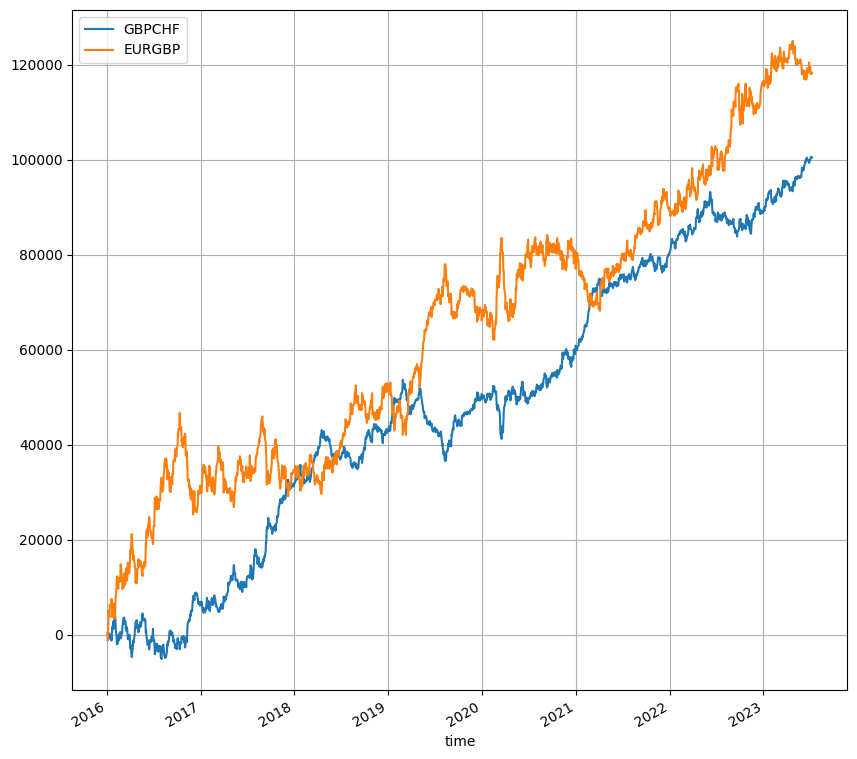

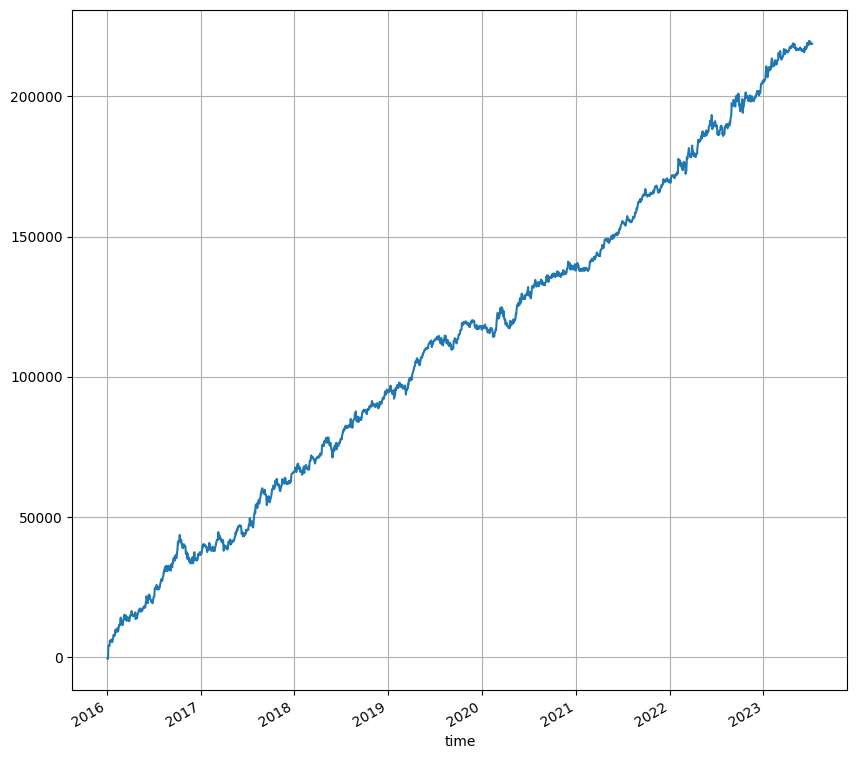

In [120]:
ID = 0

x=newdf[results[["v1","v2"]].iloc[ID].to_list()]

x.cumsum().plot(figsize=(10,10),grid=True)
plt.show()
x.cumsum().sum(axis=1).plot(figsize=(10,10),grid=True)
plt.show()

In [121]:
w=w.W.to_frame("app")

In [17]:
####################### VERSIONE NORMALE

def kestner_ratio(operations):

    import numpy as np
    import matplotlib.pyplot as plt 
    from scipy import stats
    
    monthly_operations = operations.resample('W').sum().fillna(0)
    monthly_equity = monthly_operations.cumsum()
    index = np.array(np.arange(1,monthly_operations.count() + 1))
    
    x = index
    y = monthly_equity
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    if std_err != 0 and len(index) > 0:
        return round(gradient / (std_err * len(index)),5)
    else:
        return np.inf
    
def percent_win(operations):
    return round((operations[operations > 0].count() / operations.count() * 100),2)

#w=w.W.to_frame("app")

stampa = 0
N_SPREAD = 20

today_orders = pd.DataFrame(columns=["pnl","cum","sma","newbal","sng_for_tomorrow","market_1","market_2","market_1_size","market_2_size","v_SMA"])
portfolio = pd.DataFrame()
while True:
    for i in tqdm(range(len(results))):
        if (newdf[results.iloc[:,:2].iloc[i].values].corr().iloc[:,1].iloc[0]) <-0.3:
            x=newdf[results.iloc[:,:2].iloc[i].values]
            
            x=x.resample("W").sum()
            
            x=x[x!=0]
            if stampa == 1:
                x.cumsum().plot(figsize=(10,10))
                plt.show()
                x.sum(axis=1).cumsum().plot(figsize=(10,10),title="Portfolio")
                plt.legend()
                plt.show()

            ################################################################################################
            sma_ls=[]
            ks_ls=[]
            for e in tqdm(range(2,20)):
                a=x.copy().sum(axis=1).to_frame()
                a.columns=(["pnl"])
                a["cum"]=a.iloc[:,0].cumsum()
                a["sma"]=a.cum.rolling(e).mean()
                a["newbal"]=0
                a.newbal=np.where(a.cum.shift(1)<a.sma.shift(1),a.iloc[:,0],a.newbal)
                b=a.newbal
                b=b[b!=0].dropna()
                if len(b)>0:
                    ks_ls.append(kestner_ratio(b))
                    sma_ls.append(e)
                else:
                    ks_ls.append(0)
                    sma_ls.append(0)
                    
            v_mean = sma_ls[ks_ls.index(max(ks_ls))]

            a=x.copy().sum(axis=1).to_frame()
            a.columns=(["pnl"])
            a["cum"]=a.iloc[:,0].cumsum()
            a["sma"]=a.cum.rolling(v_mean).mean()
            a["newbal"]=0
            a.newbal=np.where(a.cum.shift(1)<a.sma.shift(1),a.iloc[:,0],a.newbal)
            a["sng_for_tomorrow"]=0
            a["sng_for_tomorrow"]=np.where(a.cum<a.sma,1,a.sng_for_tomorrow)
            a["market_1"] = x.columns[0]
            a["market_2"] = x.columns[1]
            a["market_1_size"]=round(float(w.app[w.index==a.market_1.iloc[0]]),2)
            a["market_2_size"]=round(float(w.app[w.index==a.market_2.iloc[0]]),2)
            a["v_SMA"]=v_mean
            if stampa == 1:
                a[["pnl","newbal"]].cumsum().plot(figsize=(10,10))

            if True: # a.iloc[-1:].sng_for_tomorrow[-1] == 1:
                if (a["market_1"].iloc[0] not in [*today_orders["market_1"].values, *today_orders["market_2"].values])&\
                   (a["market_2"].iloc[0] not in [*today_orders["market_1"].values, *today_orders["market_2"].values]):
                        today_orders = pd.concat([today_orders,a.iloc[-1:]])
                        tmp_df = a.newbal.to_frame()
                        tmp_df.columns = ([a["market_1"].iloc[0]+"_"+a["market_2"].iloc[0]])
                        portfolio=pd.concat([portfolio,tmp_df],axis=1).fillna(0)
   
        if len(today_orders)>=N_SPREAD:
            print("Deviazione Standard")
            display(x.std())
            break
    if len(today_orders)>=N_SPREAD:
        break
        
    if i == (len(new_results)-1):
        break

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

NameError: name 'new_results' is not defined

{1.0: 0.8063063063063063, 2.0: 1.3161764705882353}

In [29]:
####################### VERSIONE ML STATICO


from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier

def kestner_ratio(operations):

    import numpy as np
    import matplotlib.pyplot as plt 
    from scipy import stats
    
    monthly_operations = operations.resample('W').sum().fillna(0)
    monthly_equity = monthly_operations.cumsum()
    index = np.array(np.arange(1,monthly_operations.count() + 1))
    
    x = index
    y = monthly_equity
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    if std_err != 0 and len(index) > 0:
        return round(gradient / (std_err * len(index)),5)
    else:
        return np.inf
    
def percent_win(operations):
    return round((operations[operations > 0].count() / operations.count() * 100),2)

#w=w.W.to_frame("app")

stampa = 0
N_SPREAD = 14

today_orders = pd.DataFrame(columns=["market_1","market_2","market_1_size","market_2_size","pred"])
portfolio = pd.DataFrame()
while True:
    for i in tqdm(range(len(results))):
        if True: #(newdf[results.iloc[:,:2].iloc[i].values].corr().iloc[:,1].iloc[0]) <-0.3:
            x=newdf[results.iloc[:,:2].iloc[i].values]
            
            x=x.resample("W").sum()
            
            x=x[x!=0]
            if stampa == 2:
                x.cumsum().plot(figsize=(10,10))
                plt.show()
                x.sum(axis=1).cumsum().plot(figsize=(10,10),title="Portfolio")
                plt.legend()
                plt.show()

            ################################################################################################
            
            X = etf_return.resample("W").sum().cumsum()
            y = x.sum(axis=1)
            y[y>0]=1
            y[y<0]=2
            y=y.shift(-1 , fill_value=0)
            
            nop = 10
            X_train = X.iloc[:-nop]
            X_test = X.iloc[-nop:] 
            y_train = y.iloc[:-nop]
            y_test = y.iloc[-nop:]   
            
            # Calcola il peso tra le classi
            class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
            class_weights = {np.unique(y_train)[0] : class_weights[0] , np.unique(y_train)[1] : class_weights[1]}
            # Crea un classificatore di regressione logistica con peso tra le classi
            clf = RandomForestClassifier(n_jobs=-1,random_state=1,max_depth=7,class_weight=class_weights)
            #clf = LogisticRegression(class_weight=dict(enumerate(class_weights)))
            # Addestramento del modello sul set di addestramento
            clf.fit(X_train, y_train)

            # Valutazione dell'accuratezza sul set di test
            accuracy = clf.score(X_train, y_train)
            accuracy2 = clf.score(X_test, y_test)

            # Stampa l'accuratezza
            print("Accuratezza Train:", accuracy)
            print("Accuratezza Test:", accuracy2)
            print("")
            
            if accuracy2 >=0.6:
                pred = clf.predict(X)
                pred = np.where(pred==2,-1,pred)
                a = x.sum(axis=1).to_frame(x.columns[0]+"_"+x.columns[1])
                a["pred"] = pred
                a["new_bal"] = a.iloc[:,0] * a.pred.shift(1)
                a["market_1"] = x.columns[0]
                a["market_2"] = x.columns[1]
                a["market_1_size"]=round(float(w.app[w.index==a.market_1.iloc[0]]),2)
                a["market_2_size"]=round(float(w.app[w.index==a.market_2.iloc[0]]),2)

                if stampa == 1:
                    a["new_bal"].cumsum().plot(figsize=(10,10),title=x.columns[0]+"_"+x.columns[1])
                    plt.axvline(x=y_test.index[0] ,color="r",linewidth=1)
                    plt.show()


                if (a["market_1"].iloc[0] not in [*today_orders["market_1"].values, *today_orders["market_2"].values])&\
                    (a["market_2"].iloc[0] not in [*today_orders["market_1"].values, *today_orders["market_2"].values]):
                    today_orders = pd.concat([today_orders,a[["market_1","market_2","market_1_size","market_2_size","pred"]].iloc[-1:]])
                    tmp_df = a.new_bal.to_frame()
                    tmp_df.columns = ([a["market_1"].iloc[0]+"_"+a["market_2"].iloc[0]])
                    portfolio=pd.concat([portfolio,tmp_df],axis=1).fillna(0)
   
        if len(today_orders)>=N_SPREAD:
            print("Deviazione Standard")
            display(x.std())
            break
    if len(today_orders)>=N_SPREAD:
        break
        
    if i == (len(results)-1):
        break

  0%|          | 0/62 [00:00<?, ?it/s]

Accuratezza Train: 0.9734748010610079
Accuratezza Test: 0.3

Accuratezza Train: 0.9708222811671088
Accuratezza Test: 0.3

Accuratezza Train: 0.9602122015915119
Accuratezza Test: 0.4

Accuratezza Train: 0.9575596816976127
Accuratezza Test: 0.5

Accuratezza Train: 0.9681697612732095
Accuratezza Test: 0.5

Accuratezza Train: 0.9363395225464191
Accuratezza Test: 0.5

Accuratezza Train: 0.9549071618037135
Accuratezza Test: 0.4

Accuratezza Train: 0.9549071618037135
Accuratezza Test: 0.5

Accuratezza Train: 0.9496021220159151
Accuratezza Test: 0.8

Accuratezza Train: 0.9655172413793104
Accuratezza Test: 0.3

Accuratezza Train: 0.9602122015915119
Accuratezza Test: 0.6

Accuratezza Train: 0.9761273209549072
Accuratezza Test: 0.4

Accuratezza Train: 0.9734748010610079
Accuratezza Test: 0.6

Accuratezza Train: 0.9336870026525199
Accuratezza Test: 0.4

Accuratezza Train: 0.9628647214854111
Accuratezza Test: 0.3

Accuratezza Train: 0.9628647214854111
Accuratezza Test: 0.3

Accuratezza Train: 0.976

def get_mean_accuracy(X2,y_data):
       
    OOS_barre = 1
    add = 100 #random.randint(97, 103)
    
    OOS_date = y_data.iloc[:-OOS_barre].index[-1]
    OOS_ls_idx = y_data.iloc[-OOS_barre:].index
    
    train , test = fast_GSA(X2.iloc[:-OOS_barre].index,add)
    
    X_train = X2.iloc[:-OOS_barre][X2.iloc[:-OOS_barre].index.isin(train)]
    X_test = X2.iloc[:-OOS_barre][X2.iloc[:-OOS_barre].index.isin(test)]
    y_train = y_data.iloc[:-OOS_barre][y_data.iloc[:-OOS_barre].index.isin(train)]
    y_test = y_data.iloc[:-OOS_barre][y_data.iloc[:-OOS_barre].index.isin(test)]
    
    indx = [*y_test.index , *OOS_ls_idx]

    rf = RandomForestClassifier(n_jobs=-1,random_state=1,max_depth=5)
    
    rf.fit(X_train, y_train)
    
    accuracy2 = rf.score(X_test, y_test)
    
    return accuracy2 , rf

In [122]:
def get_mean_accuracy(X2,y_data):
       
    OOS_barre = 1
    ls_add = np.arange(80,120,1)
    ls_accuracy=[]
    ls_models=[]
    
    for add in ls_add:
        OOS_date = y_data.iloc[:-OOS_barre].index[-1]
        OOS_ls_idx = y_data.iloc[-OOS_barre:].index

        train , test = fast_GSA(X2.iloc[:-OOS_barre].index,add)

        X_train = X2.iloc[:-OOS_barre][X2.iloc[:-OOS_barre].index.isin(train)]
        X_test = X2.iloc[:-OOS_barre][X2.iloc[:-OOS_barre].index.isin(test)]
        y_train = y_data.iloc[:-OOS_barre][y_data.iloc[:-OOS_barre].index.isin(train)]
        y_test = y_data.iloc[:-OOS_barre][y_data.iloc[:-OOS_barre].index.isin(test)]

        indx = [*y_test.index , *OOS_ls_idx]

        rf = RandomForestClassifier(n_jobs=-1,random_state=1,max_depth=5)  ##5

        rf.fit(X_train, y_train)

        accuracy2 = rf.score(X_test, y_test)
        
        ls_accuracy.append(accuracy2)
        ls_models.append(rf)
        
    v_max = ls_accuracy.index(max(ls_accuracy))
    
    return ls_accuracy[v_max] , ls_models[v_max]

In [123]:
####################### VERSIONE ML DINAMICO

from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier

def fast_GSA(dataframe,n_split):
    newdf_split = np.array_split(dataframe, n_split)
    return np.concatenate(newdf_split[0::2]) , np.concatenate(newdf_split[1::2])



def kestner_ratio(operations):

    import numpy as np
    import matplotlib.pyplot as plt 
    from scipy import stats
    
    monthly_operations = operations.resample('W').sum().fillna(0)
    monthly_equity = monthly_operations.cumsum()
    index = np.array(np.arange(1,monthly_operations.count() + 1))
    
    x = index
    y = monthly_equity
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    if std_err != 0 and len(index) > 0:
        return round(gradient / (std_err * len(index)),5)
    else:
        return np.inf
    
def percent_win(operations):
    return round((operations[operations > 0].count() / operations.count() * 100),2)

#w=w.W.to_frame("app")

stampa = 0
N_SPREAD = 14

today_orders = pd.DataFrame(columns=["market_1","market_2","market_1_size","market_2_size","pred"])
portfolio = pd.DataFrame()
while True:
    for i in tqdm(range(len(results))):
        if True: #(newdf[results.iloc[:,:2].iloc[i].values].corr().iloc[:,1].iloc[0]) <-0.3:
            x=newdf[results.iloc[:,:2].iloc[i].values]
            
            x=x.resample("W").sum()
            
            x=x[x!=0]
            if stampa == 2:
                x.cumsum().plot(figsize=(10,10))
                plt.show()
                x.sum(axis=1).cumsum().plot(figsize=(10,10),title="Portfolio")
                plt.legend()
                plt.show()

            ################################################################################################
            
            X = etf_return.resample("W").sum().cumsum()
            y = x.sum(axis=1)
            y[y>0]=1
            y[y<0]=-1
            y=y.shift(-1 , fill_value=0)
            

            accuracy , rf = get_mean_accuracy(X,y)
            print("Accuratezza Train:", accuracy)
            print("")
            #display(pred)
            if accuracy >=0.6:
                a = x.sum(axis=1).to_frame(x.columns[0]+"_"+x.columns[1])
                a["pred"] = rf.predict(X)
                a["pred"] = a["pred"].shift(1)
                a["new_bal"] = a.iloc[:,0] * a.pred #.shift(1)
                a["market_1"] = x.columns[0]
                a["market_2"] = x.columns[1]
                a["market_1_size"]=round(float(w.app[w.index==a.market_1.iloc[0]]),2)
                a["market_2_size"]=round(float(w.app[w.index==a.market_2.iloc[0]]),2)

                if stampa == 1:
                    a["new_bal"].cumsum().plot(figsize=(10,10),title=x.columns[0]+"_"+x.columns[1])
                    #plt.axvline(x=y.iloc[-10:].index[0] ,color="r",linewidth=1)
                    plt.show()

                if True: # a.iloc[-1:].sng_for_tomorrow[-1] == 1:
                    if (a["market_1"].iloc[0] not in [*today_orders["market_1"].values, *today_orders["market_2"].values])&\
                       (a["market_2"].iloc[0] not in [*today_orders["market_1"].values, *today_orders["market_2"].values]):
                            today_orders = pd.concat([today_orders,a[["market_1","market_2","market_1_size","market_2_size","pred"]].iloc[-1:]])
                            tmp_df = a.new_bal.to_frame()
                            tmp_df.columns = ([a["market_1"].iloc[0]+"_"+a["market_2"].iloc[0]])
                            portfolio=pd.concat([portfolio,tmp_df],axis=1).fillna(0)
   
        if len(today_orders)>=N_SPREAD:
            print("Deviazione Standard")
            display(x.std())
            break
    if len(today_orders)>=N_SPREAD:
        break
        
    if i == (len(results)-1):
        break

  0%|          | 0/62 [00:00<?, ?it/s]

Accuratezza Train: 0.5979381443298969

Accuratezza Train: 0.6082474226804123

Accuratezza Train: 0.5876288659793815

Accuratezza Train: 0.6632653061224489

Accuratezza Train: 0.5876288659793815

Accuratezza Train: 0.6443298969072165

Accuratezza Train: 0.673469387755102

Accuratezza Train: 0.6185567010309279

Accuratezza Train: 0.6173469387755102

Accuratezza Train: 0.6479591836734694

Accuratezza Train: 0.6649484536082474

Accuratezza Train: 0.576530612244898

Accuratezza Train: 0.6701030927835051

Accuratezza Train: 0.6855670103092784

Accuratezza Train: 0.6377551020408163

Accuratezza Train: 0.5773195876288659

Accuratezza Train: 0.6020408163265306

Accuratezza Train: 0.6134020618556701

Accuratezza Train: 0.6887755102040817

Accuratezza Train: 0.6173469387755102

Accuratezza Train: 0.6288659793814433

Accuratezza Train: 0.6173469387755102

Accuratezza Train: 0.6326530612244898

Accuratezza Train: 0.576530612244898

Accuratezza Train: 0.5918367346938775

Accuratezza Train: 0.5824742

In [90]:
results

,v1,v2,kr,avg_trade,corr
0,GBPCHF,EURGBP,0.30043,113.556550,-0.735556
1,GBPCAD,EURGBP,0.18695,110.439980,-0.450764
2,EURGBP,GBPUSD,0.15863,113.993108,-0.526149
3,NZDCAD,AUDNZD,0.15201,102.984881,-0.412945
4,GBPNZD,EURGBP,0.14594,109.025632,-0.399351
5,CADCHF,GBPCAD,0.14530,102.093737,-0.449478
6,EURNZD,NZDUSD,0.13446,104.361249,-0.661375
7,GBPAUD,AUDUSD,0.13339,107.280721,-0.502195
8,AUDCAD,GBPAUD,0.13300,102.334919,-0.427504
9,GBPNZD,NZDCAD,0.12933,100.573808,-0.450449


def get_mean_accuracy(X,y):

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score

    window_size = 300  # Dimensione della finestra temporale
    overlap = 3  # Sovrapposizione tra le finestre successive

    accuracies = []  # Lista per memorizzare le accuratezze delle diverse finestre
    predicts_ls = pd.DataFrame()
    for i in tqdm(range(0, len(X) - window_size, overlap)):
        # Definisci la finestra di addestramento e di test
        X_train = X[i:i+window_size]
        y_train = y[i:i+window_size]
        X_test = X[i+window_size:i+window_size+overlap]
        y_test = y[i+window_size:i+window_size+overlap]
        #print(len(X_train),len(y_train))
        # Crea e addestra il modello Random Forest
        rf = RandomForestClassifier(n_jobs=-1,random_state=1,max_depth=None)
        rf.fit(X_train, y_train)

        # Effettua le previsioni sulla finestra di test
        y_pred = rf.predict(X_test)
        
        tmp = y_test.to_frame()
        tmp["pred"] = y_pred
        predicts_ls = pd.concat([predicts_ls,tmp.pred])
        # Calcola l'accuratezza per questa finestra e aggiungila alla lista
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Calcola l'accuratezza media su tutte le finestre
    average_accuracy = sum(accuracies) / len(accuracies)
    return average_accuracy , rf , predicts_ls

def get_mean_accuracy(X,y):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.model_selection import TimeSeriesSplit

    window_size = 10  # Dimensione della finestra temporale

    # Crea l'oggetto TimeSeriesSplit con il numero desiderato di fold
    tscv = TimeSeriesSplit(n_splits=len(X) // window_size)

    accuracies = []  # Lista per memorizzare le accuratezze delle diverse finestre
    predicts_ls = pd.DataFrame()
    for train_index, test_index in tscv.split(X):
        # Definisci la finestra di addestramento e di test
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        print(len(X_train),len(y_train))
        
        # Crea e addestra il modello Random Forest
        rf = RandomForestClassifier(n_jobs=-1,random_state=1,max_depth=7)
        rf.fit(X_train, y_train)

        # Effettua le previsioni sulla finestra di test
        y_pred = rf.predict(X_test)
        
        tmp = y_test.to_frame()
        tmp["pred"] = y_pred
        predicts_ls = pd.concat([predicts_ls,tmp.pred])
        # Calcola l'accuratezza per questa finestra e aggiungila alla lista
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Calcola l'accuratezza media su tutte le finestre
    average_accuracy = sum(accuracies) / len(accuracies)
    
    return average_accuracy , rf , predicts_ls

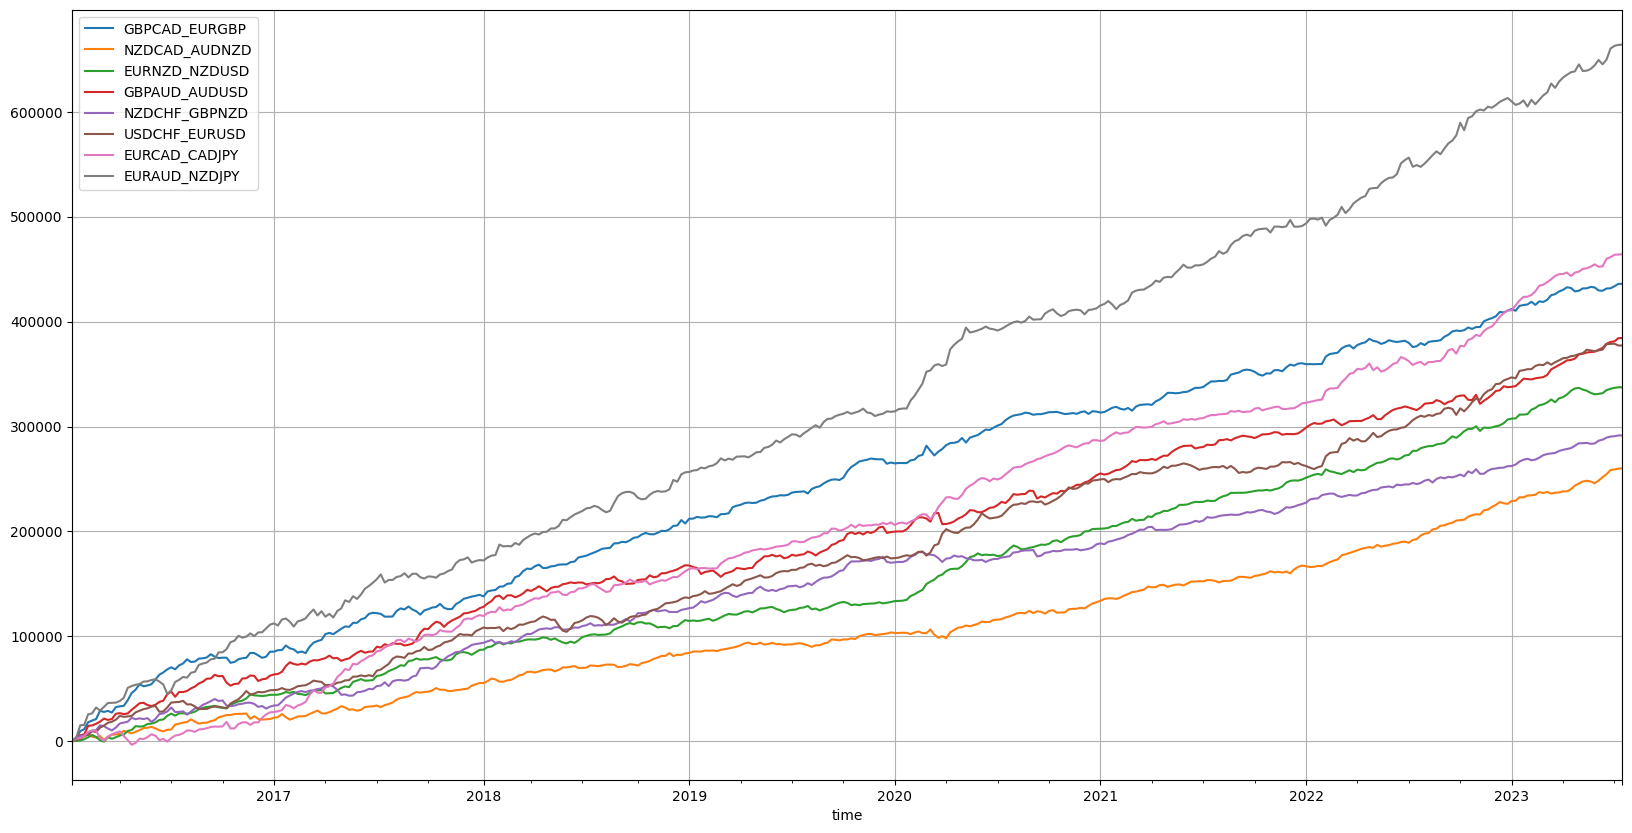

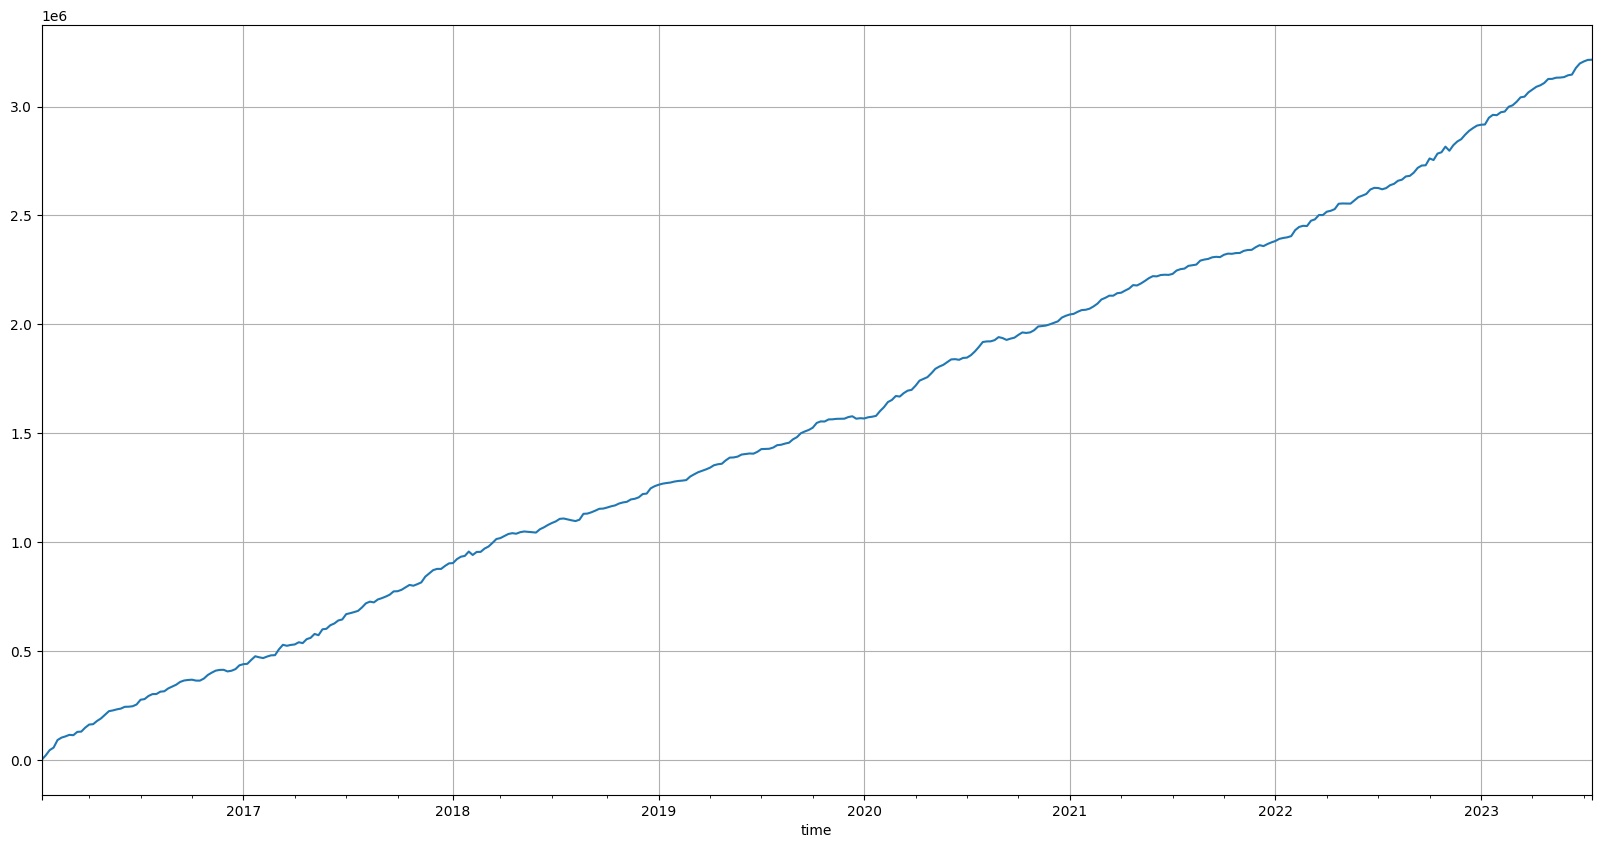

In [124]:
portfolio.cumsum().plot(figsize=(20,10),grid=True)
plt.show()
portfolio.sum(axis=1).cumsum().plot(figsize=(20,10),grid=True)
plt.show()

In [125]:
portfolio.cumsum().std()

GBPCAD_EURGBP    119302.617780
NZDCAD_AUDNZD     68898.105826
EURNZD_NZDUSD     94670.835845
GBPAUD_AUDUSD    100609.540057
NZDCHF_GBPNZD     80539.171795
USDCHF_EURUSD    104071.006411
EURCAD_CADJPY    131036.414118
EURAUD_NZDJPY    179747.963079
dtype: float64

In [126]:
portfolio.sum(axis=1).tail(10)

time
2023-05-14     5384.187519
2023-05-21      563.464921
2023-05-28     2136.630667
2023-06-04     8324.520008
2023-06-11     3210.130227
2023-06-18    30476.280800
2023-06-25    20723.242117
2023-07-02     9133.039094
2023-07-09     7084.575597
2023-07-16      892.577695
Freq: W-SUN, dtype: float64

<Axes: xlabel='time'>

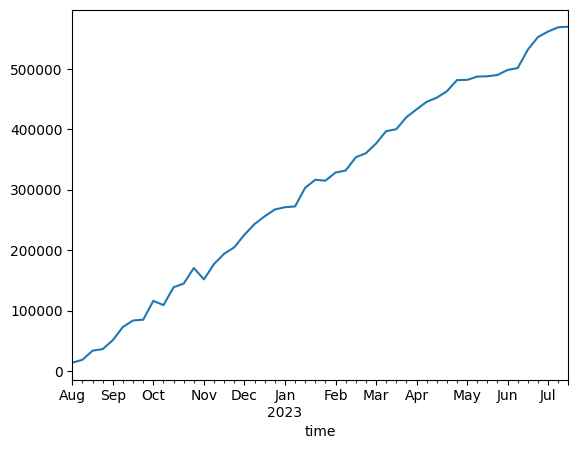

In [127]:
portfolio.sum(axis=1).iloc[-50:].cumsum().plot()

In [128]:
percent_win(portfolio.sum(axis=1))

88.3

In [135]:
n=portfolio.sum(axis=1)
n[n<0].min()

-18787.138776444925

In [133]:
today_orders.market_1_size.sum()+today_orders.market_2_size.sum()

37.92

In [26]:
len(n[n<0])

82

In [27]:
len(n)

392

In [28]:
len(n[n>0])

309

In [29]:
portfolio.sum(axis=1).max()

40858.39035796379

In [99]:
today_orders

,market_1,market_2,market_1_size,market_2_size,pred,pnl_live,pnl_live_S1,pnl_live_S2
2023-07-02,GBPCHF,EURGBP,1.00,2.62,-1.0,157.932679,-854.017367,1011.950046
2023-07-02,NZDCAD,AUDNZD,2.04,3.36,1.0,811.444067,2112.508927,-1301.064860
2023-07-02,CADCHF,GBPCAD,1.99,1.67,1.0,2452.397423,-632.464963,3084.862385
2023-07-02,EURNZD,NZDUSD,2.24,1.94,1.0,514.337281,-1105.778321,1620.115603
2023-07-02,GBPAUD,AUDUSD,1.99,2.50,1.0,3158.629378,1909.609448,1249.019930
2023-07-02,NZDCHF,GBPNZD,1.37,1.68,1.0,792.099977,827.289597,-35.189620
2023-07-02,EURUSD,USDCHF,3.46,2.05,1.0,1673.242126,2223.893660,-550.651534
2023-07-02,USDCAD,NZDJPY,3.20,1.91,1.0,981.423786,936.109433,45.314353


In [96]:
portfolio.sum(axis=1).tail()

time
2023-06-04     7880.518503
2023-06-11     2279.467626
2023-06-18    14146.841179
2023-06-25     6722.323899
2023-07-02     4579.840967
Freq: W-SUN, dtype: float64

In [129]:
import datetime
path=(r"C:\Program Files\ICMarkets - MetaTrader 5 3\terminal64.exe")
import time
from IPython.display import clear_output

while True:
    clear_output(wait=True)
    time.sleep(2)
    now = datetime.datetime.now()
    print(now)
    if (now.hour==0)&((now.minute==0)):
        for e in range(len(today_orders)):
            x=today_orders.iloc[e]
            
            if x.pred==1:
                direz="long"
            if x.pred==-1:
                direz="short"
            
            ordine_market(x.market_1.split("_")[0],float(x.market_1_size),1,path,direz,"Spread_"+str(e))
            #time.sleep(0.1)
            ordine_market(x.market_2.split("_")[0],float(x.market_2_size),1,path,direz,"Spread_"+str(e))
            #time.sleep(0.1)
        break


2023-07-10 00:00:01.591900
OrderSendResult(retcode=10009, deal=311396780, order=436552676, volume=1.74, price=1.70514, bid=1.70392, ask=1.70514, comment='Request executed', request_id=3340071505, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='GBPCAD', volume=1.74, price=1.70514, stoplimit=0.0, sl=0.0, tp=0.0, deviation=1, type=0, type_filling=1, type_time=0, expiration=0, comment='Spread_0', position=0, position_by=0)) Request executed
OrderSendResult(retcode=10009, deal=311396831, order=436552803, volume=2.62, price=0.85472, bid=0.85422, ask=0.85472, comment='Request executed', request_id=3340071506, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='EURGBP', volume=2.62, price=0.85472, stoplimit=0.0, sl=0.0, tp=0.0, deviation=1, type=0, type_filling=1, type_time=0, expiration=0, comment='Spread_0', position=0, position_by=0)) Request executed
OrderSendResult(retcode=10009, deal=311396857, order=436552881, volume=2.04, price=0.82

In [130]:
import datetime
path=(r"C:\Program Files\ICMarkets - MetaTrader 5 3\terminal64.exe")
import time
from IPython.display import clear_output

"""while True:
    clear_output(wait=True)
    time.sleep(2)
    now = datetime.datetime.now()"""
print(now)
#if (now.hour==0)&((now.minute==0)):
for e in range(len(today_orders)):
    x=today_orders.iloc[e]

    if x.pred==1:
        direz="long"
    if x.pred==-1:
        direz="short"

    ordine_market(x.market_1.split("_")[0],float(x.market_1_size),1,path,direz,"Spread_"+str(e))
    #time.sleep(0.1)
    ordine_market(x.market_2.split("_")[0],float(x.market_2_size),1,path,direz,"Spread_"+str(e))
    #time.sleep(0.1)

2023-07-10 00:00:01.591900
OrderSendResult(retcode=10009, deal=311400512, order=436559213, volume=1.74, price=1.7046299999999999, bid=1.70435, ask=1.7046299999999999, comment='Request executed', request_id=3340071547, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='GBPCAD', volume=1.74, price=1.7046299999999999, stoplimit=0.0, sl=0.0, tp=0.0, deviation=1, type=0, type_filling=1, type_time=0, expiration=0, comment='Spread_0', position=0, position_by=0)) Request executed
OrderSendResult(retcode=10009, deal=311400516, order=436559217, volume=2.62, price=0.85438, bid=0.85429, ask=0.85438, comment='Request executed', request_id=3340071548, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='EURGBP', volume=2.62, price=0.85438, stoplimit=0.0, sl=0.0, tp=0.0, deviation=1, type=0, type_filling=1, type_time=0, expiration=0, comment='Spread_0', position=0, position_by=0)) Request executed
OrderSendResult(retcode=10009, deal=311400520, order=4

In [142]:
############## verifica live 

start_date = "2023-07-09"


today_orders["pnl_live"]=0
today_orders["pnl_live_S1"]=0
today_orders["pnl_live_S2"]=0
for e in range(len(today_orders)):
    x=today_orders.iloc[e]
    
    y=readdata(x.market_1.split("_")[0],"W1",10,path)
    y=y.loc[start_date:]
    y=(y.close-y.open)*get_poin_values(path,x.market_1.split("_")[0])*x.market_1_size
    if x.pred == -1:
        y=y*(-1)
    p1 = y.sum()
    
    y=readdata(x.market_2.split("_")[0],"W1",10,path)
    y=y.loc[start_date:]
    y=(y.close-y.open)*get_poin_values(path,x.market_2.split("_")[0])*x.market_2_size
    if x.pred == -1:
        y=y*(-1)
    p2 = y.sum()
    
    today_orders["pnl_live"].iloc[e]=float(p1)+float(p2)
    today_orders["pnl_live_S1"].iloc[e]=float(p1)
    today_orders["pnl_live_S2"].iloc[e]=float(p2)
    
display(today_orders)

print("Pnl Weekly:", round(today_orders.pnl_live.sum()) , "€")

,market_1,market_2,market_1_size,market_2_size,pred,pnl_live,pnl_live_S1,pnl_live_S2
2023-07-16,GBPCAD,EURGBP,1.74,2.62,1.0,3824.230996,2848.139411,976.091585
2023-07-16,NZDCAD,AUDNZD,2.04,3.36,1.0,2382.923674,2382.923674,0.000000
2023-07-16,EURNZD,NZDUSD,2.24,1.94,1.0,3026.946061,-402.973939,3429.920000
2023-07-16,GBPAUD,AUDUSD,1.99,2.50,-1.0,-3661.553323,680.946677,-4342.500000
2023-07-16,NZDCHF,GBPNZD,1.37,1.68,-1.0,1113.852204,221.093451,892.758754
2023-07-16,USDCHF,EURUSD,2.05,3.47,-1.0,-3002.687074,6557.162926,-9559.850000
2023-07-16,EURCAD,CADJPY,2.93,2.27,1.0,2682.336243,4918.636329,-2236.300086
2023-07-16,EURAUD,NZDJPY,3.81,1.91,1.0,466.906399,-5.225339,472.131738


Pnl Weekly: 6833 €


In [143]:
portfolio.tail()

,GBPCAD_EURGBP,NZDCAD_AUDNZD,EURNZD_NZDUSD,GBPAUD_AUDUSD,NZDCHF_GBPNZD,USDCHF_EURUSD,EURCAD_CADJPY,EURAUD_NZDJPY
time,,,,,,,,
2023-06-18,2144.315228,2731.802761,2892.860891,3992.186880,1920.550521,5170.443988,7236.969441,4387.151090
2023-06-25,167.944999,3971.330711,1291.703325,1756.016484,1062.987411,304.441973,1538.795571,10630.021644
2023-07-02,2013.379210,621.361439,894.568251,486.576873,260.068811,79.546488,2234.695769,2542.842253
2023-07-09,2196.631831,813.387470,518.026007,3153.853658,792.901228,-1682.328610,295.043227,997.060787
2023-07-16,169.946516,210.994221,39.546417,52.161002,9.268161,38.113834,272.682658,99.864885
